In [1]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def select_makespan(failure_type: str, success_or_not: bool) -> pd.DataFrame:
    # Connect to the SQLite database
    conn = sqlite3.connect('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/mapreduce.db')

    # Query to extract relevant records
    query = f"""
    SELECT failure_track, makespan, resilience
    FROM workflow 
    WHERE makespan IS NOT NULL
    AND failure_type IS '{failure_type}'
    AND workflow_finish IS {success_or_not}
    AND failure_rate_set IS '0.3'
    ORDER BY failure_track;
    """

    # Load data into a DataFrame
    df = pd.read_sql_query(query, conn)

    # Close the database connection
    conn.close()

    return df


In [6]:
def draw_time2failure(df: pd.DataFrame, failure_type: str, success_or_not: bool) -> None:
    sns.set_theme(style="whitegrid")
    sns.set_palette("pastel")
    
    plt.figure(figsize=(5, 3) if success_or_not else (5, 3))
    
    sns.boxplot(x='failure_track', y='makespan', hue='resilience', data=df)
    
    plt.xlabel('#failed tasks in Map/Reduce stage', fontsize=14)
    plt.ylabel('Time to Success (s)' if success_or_not else 'Time to Failure (s)', fontsize=14)
    # plt.title(f'Failure Type = {failure_type}', fontsize=16)
    # if resilience=1, write 'with WRATH', else write 'without WRATH'

    # 获取当前图例
    handles, labels = plt.gca().get_legend_handles_labels()

    # 根据 resilience 的值设置每个图例项的标签
    new_labels = [f'Parsl w/ WRATH' if '1' in label else f'Parsl' for label in labels]

    # 绘制图例并设置新的标签
    plt.legend(handles, new_labels, fontsize=8)


    # plt.legend(title='WRATH', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/img/mapreduce_{failure_type}_{success_or_not}.pdf')
    plt.show()


In [19]:
def draw_time2failure(df: pd.DataFrame, failure_type: str, success_or_not: bool) -> None:
    sns.set_theme(style="whitegrid")
    sns.set_palette("pastel")
    
    # Calculate mean and standard error for each group
    summary_df = df.groupby(['failure_track', 'resilience']).agg(
        mean_makespan=('makespan', 'mean'),
        stderr_makespan=('makespan', 'sem')
    ).reset_index()
    
    plt.figure(figsize=(5, 3) if success_or_not else (5, 3))
    
    # Create the bar plot
    ax = sns.barplot(x='failure_track', y='mean_makespan', hue='resilience', data=summary_df, ci=None)
    
    # Add error bars manually
    for i, bar in enumerate(ax.patches):
        # Calculate the index for the summary_df
        failure_track_index = i // len(summary_df['resilience'].unique())
        resilience_index = i % len(summary_df['resilience'].unique())
        if failure_track_index < len(summary_df['failure_track'].unique()) and resilience_index < len(summary_df['resilience'].unique()):
            row = summary_df[(summary_df['failure_track'] == summary_df['failure_track'].unique()[failure_track_index]) & 
                             (summary_df['resilience'] == summary_df['resilience'].unique()[resilience_index])]
            if not row.empty:
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()
                yerr = row['stderr_makespan'].values[0]
                plt.errorbar(x=x, y=y, yerr=yerr, fmt='none', c='black', capsize=0)
    
    plt.xlabel('Failure Track', fontsize=14)
    plt.ylabel('Time to Success (s)' if success_or_not else 'Time to Failure (s)', fontsize=14)
    plt.legend(title='WRATH', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/img/mapreduce_{failure_type}_{success_or_not}.pdf', bbox_inches='tight')
    plt.show()

# Example usage
# df = pd.read_csv('your_data.csv')  # Load your data into a DataFrame
# draw_time2failure(df, 'import', True)

In [4]:
def draw(failure_type: str, success_or_not: bool) -> None:
    df = select_makespan(failure_type, success_or_not)
    draw_time2failure(df, failure_type, success_or_not)

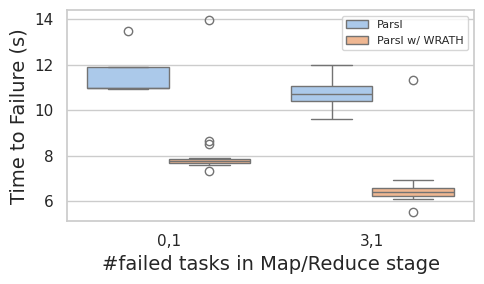

In [7]:
# draw('import', True)
draw('import', False)

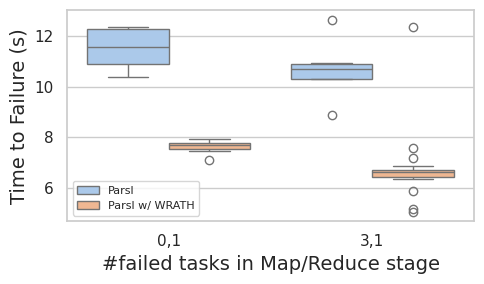

In [8]:
# draw('zero-division', True)
draw('zero-division', False)

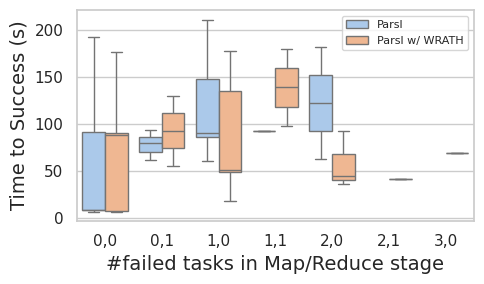

In [9]:
draw('memory', True)

In [34]:
# 3 subplots, each subplot for one failure_type. x axis is failure_rate_set, y axis is normalized_time_to_failure, hue is failure_track
# normalized_time_to_failure is resilience=1 divided by resilience=0

def select_normalized_time2failure(failure_type: str, success_or_not: bool) -> pd.DataFrame:
    # Connect to the SQLite database
    conn = sqlite3.connect('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/mapreduce.db')

    # Query to extract relevant records
    query = f"""
    SELECT failure_track, failure_rate_set, makespan, resilience
    FROM workflow 
    WHERE makespan IS NOT NULL
    AND failure_type IS '{failure_type}'
    AND workflow_finish IS {success_or_not}
    ORDER BY failure_track;
    """

    # Load data into a DataFrame
    df = pd.read_sql_query(query, conn)

    # Close the database connection
    conn.close()

    return df

/tmp/ipykernel_217526/3622547054.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x='failure_rate_set', y='normalized_time_to_failure', hue='failure_track', data=summary_df, marker='o', ci=None)


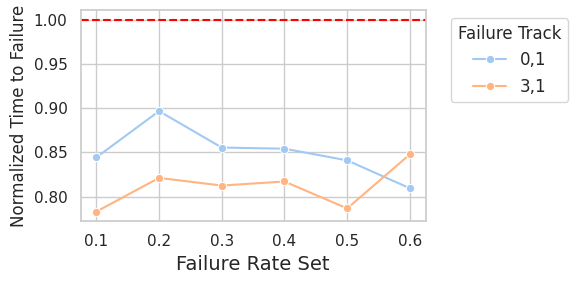

In [41]:
def draw_normalized_time2failure(df: pd.DataFrame, failure_type: str, success_or_not: bool) -> None:
    sns.set_theme(style="whitegrid")
    sns.set_palette("pastel")
    
    # Calculate mean and standard error for each group
    # 统计groupby之后每个group的记录条数，画图时只画有10条记录以上的group
    summary_df = df.groupby(['failure_track', 'failure_rate_set', 'resilience']).agg(
        mean_makespan=('makespan', 'mean')
    ).reset_index()
    
    # Calculate the normalized time to failure
    summary_df['normalized_time_to_failure'] = summary_df.groupby(['failure_track', 'failure_rate_set'])['mean_makespan'].transform(lambda x: x / x.iloc[0])
    
    plt.figure(figsize=(6, 3) if success_or_not else (6, 3))
    
    # Create the line plot
    ax = sns.lineplot(x='failure_rate_set', y='normalized_time_to_failure', hue='failure_track', data=summary_df, marker='o', ci=None)

    # Add a horizontal line at y=1
    plt.axhline(y=1, color='red', linestyle='--')

    plt.xlabel('Failure Rate Set', fontsize=14)
    plt.ylabel('Normalized Time to Success' if success_or_not else 'Normalized Time to Failure', fontsize=12)
    plt.legend(title='Failure Track', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.set_ylim(0.5, 1.2)

    plt.tight_layout()
    # plt.savefig(f'/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/img/rate_{failure_type}_{success_or_not}.pdf', bbox_inches='tight')
    plt.show()

def draw_normalized(failure_type: str, success_or_not: bool) -> None:
    df = select_normalized_time2failure(failure_type, success_or_not)
    draw_normalized_time2failure(df, failure_type, success_or_not)

draw_normalized('import', False)

   failure_track  failure_rate_set  resilience  mean_makespan  \
0            0,1               0.1           0      11.553334   
1            0,1               0.1           1       7.954010   
2            0,1               0.2           0      10.867010   
3            0,1               0.2           1       8.618995   
4            0,1               0.3           0      11.649392   
5            0,1               0.3           1       8.280997   
6            0,1               0.4           0      11.395006   
7            0,1               0.4           1       8.069902   
8            0,1               0.5           0      11.216429   
9            0,1               0.5           1       7.647575   
10           0,1               0.6           0      12.208336   
11           0,1               0.6           1       7.553536   
12           3,1               0.1           0      10.801993   
13           3,1               0.1           1       6.113495   
14           3,1         

/tmp/ipykernel_217526/1247619976.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x='failure_rate_set', y='normalized_time_to_failure', hue='failure_track', data=summary_df, marker='o', ci=None)


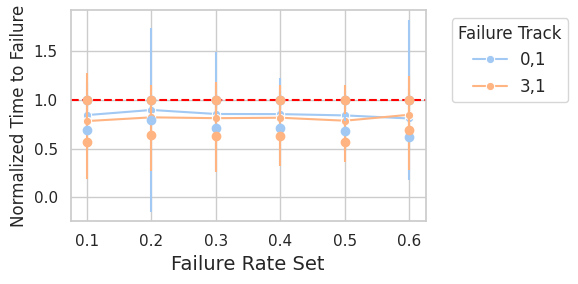

In [45]:
def draw_normalized_time2failure(df: pd.DataFrame, failure_type: str, success_or_not: bool) -> None:
    sns.set_theme(style="whitegrid")
    sns.set_palette("pastel")
    
    # Calculate mean and standard error for each group
    summary_df = df.groupby(['failure_track', 'failure_rate_set', 'resilience']).agg(
        mean_makespan=('makespan', 'mean'),
        stderr_makespan=('makespan', 'sem')
    ).reset_index()
    
    # Calculate the normalized time to failure
    summary_df['normalized_time_to_failure'] = summary_df.groupby(['failure_track', 'failure_rate_set'])['mean_makespan'].transform(lambda x: x / x.iloc[0])
    print(summary_df)
    
    plt.figure(figsize=(6, 3) if success_or_not else (6, 3))
    
    # Create the line plot
    ax = sns.lineplot(x='failure_rate_set', y='normalized_time_to_failure', hue='failure_track', data=summary_df, marker='o', ci=None)
    line_colors = {line.get_label(): line.get_color() for line in ax.get_lines()}

    # Add error bars manually
    for i, row in summary_df.iterrows():
        plt.errorbar(x=row['failure_rate_set'], y=row['normalized_time_to_failure'], yerr=row['stderr_makespan'], fmt='o', color=line_colors[row['failure_track']], capsize=0)


    # Add a horizontal line at y=1
    plt.axhline(y=1, color='red', linestyle='--')

    plt.xlabel('Failure Rate Set', fontsize=14)
    plt.ylabel('Normalized Time to Success' if success_or_not else 'Normalized Time to Failure', fontsize=12)
    plt.legend(title='Failure Track', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.set_ylim(0.5, 1.2)

    plt.tight_layout()
    # plt.savefig(f'/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/img/rate_{failure_type}_{success_or_not}.pdf', bbox_inches='tight')
    plt.show()

def draw_normalized(failure_type: str, success_or_not: bool) -> None:
    df = select_normalized_time2failure(failure_type, success_or_not)
    draw_normalized_time2failure(df, failure_type, success_or_not)

draw_normalized('import', False)

/tmp/ipykernel_217526/2714234084.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x='failure_rate_set', y='normalized_time_to_failure', hue='failure_track', data=summary_df, marker='o', ci=None)


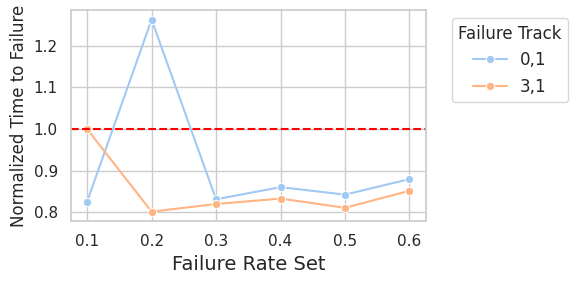

In [36]:
draw_normalized('zero-division', False)

0,0 0.0 0 43
0,0 0.0 1 50
0,0 0.1 0 31
0,0 0.1 1 42
0,0 0.2 0 28
0,0 0.2 1 33
0,0 0.3 0 19
0,0 0.3 1 25
0,0 0.4 0 23
0,0 0.4 1 26
0,0 0.5 0 10
0,0 0.5 1 17
0,0 0.6 0 10
0,0 0.6 1 12
0,1 0.1 0 1
0,1 0.1 1 1
0,1 0.2 0 1
0,1 0.2 1 3
0,1 0.3 0 3
0,1 0.3 1 2
0,1 0.4 0 2
0,1 0.4 1 5
0,1 0.5 0 4
0,1 0.5 1 6
0,1 0.6 0 5
0,1 0.6 1 6
1,0 0.1 0 10
1,0 0.1 1 7
1,0 0.2 0 12
1,0 0.2 1 10
1,0 0.3 0 16
1,0 0.3 1 16
1,0 0.4 0 12
1,0 0.4 1 10
1,0 0.5 0 12
1,0 0.5 1 15
1,0 0.6 0 11
1,0 0.6 1 14
1,1 0.2 1 1
1,1 0.3 0 1
1,1 0.3 1 2
1,1 0.4 1 3
1,1 0.5 0 1
1,1 0.5 1 6
1,1 0.6 0 1
1,1 0.6 1 9
2,0 0.1 0 1
2,0 0.2 0 1
2,0 0.2 1 2
2,0 0.3 0 2
2,0 0.3 1 3
2,0 0.4 0 2
2,0 0.4 1 4
2,0 0.5 0 3
2,0 0.5 1 4
2,0 0.6 0 4
2,0 0.6 1 4
2,1 0.3 1 1
2,1 0.4 0 1
2,1 0.5 0 3
2,1 0.5 1 2
2,1 0.6 0 1
2,1 0.6 1 3
3,0 0.3 1 1
3,1 0.4 1 1
3,1 0.6 1 1


/tmp/ipykernel_217526/1999456091.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x='failure_rate_set', y='normalized_time_to_failure', hue='failure_track', data=summary_df, marker='o', ci=None)


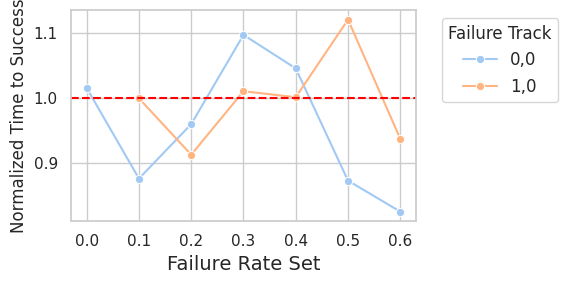

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def draw_normalized_time2failure(df: pd.DataFrame, failure_type: str, success_or_not: bool) -> None:
    sns.set_theme(style="whitegrid")
    sns.set_palette("pastel")
    
    # Group by and calculate the size of each group
    group_sizes = df.groupby(['failure_track', 'failure_rate_set', 'resilience']).size().reset_index(name='counts')
    # print(group_sizes)
    # print the whole group_sizes
    for index, row in group_sizes.iterrows():
        print(row['failure_track'], row['failure_rate_set'], row['resilience'], row['counts'])

    
    # Filter groups with counts >= 10
    filtered_groups = group_sizes[group_sizes['counts'] >= 10]
    
    # Merge the filtered groups back with the original dataframe
    filtered_df = pd.merge(df, filtered_groups[['failure_track', 'failure_rate_set', 'resilience']], on=['failure_track', 'failure_rate_set', 'resilience'])
    
    # Calculate mean and standard error for each group
    summary_df = filtered_df.groupby(['failure_track', 'failure_rate_set', 'resilience']).agg(
        mean_makespan=('makespan', 'mean')
    ).reset_index()
    
    # Calculate the normalized time to failure
    summary_df['normalized_time_to_failure'] = summary_df.groupby(['failure_track', 'failure_rate_set'])['mean_makespan'].transform(lambda x: x / x.iloc[0])
    
    plt.figure(figsize=(6, 3) if success_or_not else (6, 3))
    
    # Create the line plot
    ax = sns.lineplot(x='failure_rate_set', y='normalized_time_to_failure', hue='failure_track', data=summary_df, marker='o', ci=None)

    # Add a horizontal line at y=1
    plt.axhline(y=1, color='red', linestyle='--')

    plt.xlabel('Failure Rate Set', fontsize=14)
    plt.ylabel('Normalized Time to Success' if success_or_not else 'Normalized Time to Failure', fontsize=12)
    plt.legend(title='Failure Track', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.set_ylim(0.5, 1.2)

    plt.tight_layout()
    # plt.savefig(f'/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/img/mapreduce_{failure_type}_{success_or_not}.pdf', bbox_inches='tight')
    plt.show()

def draw_normalized(failure_type: str, success_or_not: bool) -> None:
    df = select_normalized_time2failure(failure_type, success_or_not)
    draw_normalized_time2failure(df, failure_type, success_or_not)


draw_normalized('memory', True)

In [37]:
# 画出failure_track=(1,0)时ressilience=1和resilience=0的平均makespan随failure_rate_set的变化
def select_makespan(failure_track) -> pd.DataFrame:
    # Connect to the SQLite database
    conn = sqlite3.connect('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/mapreduce.db')

    # Query to extract relevant records
    query = f"""
    SELECT failure_rate_set, makespan, resilience
    FROM workflow 
    WHERE makespan IS NOT NULL
    AND failure_track IS '{failure_track}'
    AND workflow_finish IS 1
    ORDER BY failure_rate_set;
    """

    # Load data into a DataFrame
    df = pd.read_sql_query(query, conn)

    # Close the database connection
    conn.close()

    return df



/tmp/ipykernel_217526/4257260242.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x='failure_rate_set', y='mean_makespan', hue='resilience', data=summary_df, marker='o', ci=None)


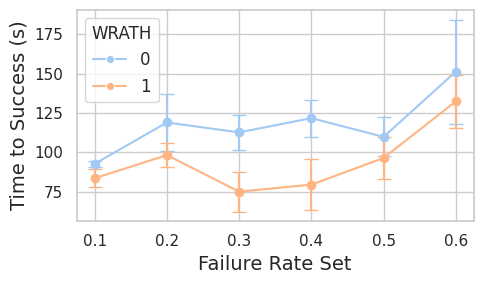

In [38]:
def draw_makespan(failure_track: str) -> None:
    df = select_makespan(failure_track)
    
    sns.set_theme(style="whitegrid")
    sns.set_palette("pastel")
    
    # Calculate mean and standard error for each group
    summary_df = df.groupby(['failure_rate_set', 'resilience']).agg(
        mean_makespan=('makespan', 'mean'),
        stderr_makespan=('makespan', 'sem')
    ).reset_index()
    
    plt.figure(figsize=(5, 3))
    
    # Create the line plot
    ax = sns.lineplot(x='failure_rate_set', y='mean_makespan', hue='resilience', data=summary_df, marker='o', ci=None)
    line_colors = {str(line.get_label()): line.get_color() for line in ax.get_lines()}

    # Add error bars manually
    for i, row in summary_df.iterrows():
        plt.errorbar(x=row['failure_rate_set'], y=row['mean_makespan'], yerr=row['stderr_makespan'], fmt='o', color=line_colors[str(int(row['resilience']))], capsize=5)

    plt.xlabel('Failure Rate Set', fontsize=14)
    plt.ylabel('Time to Success (s)', fontsize=14)
    plt.legend(title='WRATH', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/img/rate_{failure_track}.pdf', bbox_inches='tight')
    plt.show()

draw_makespan('1,0')